In [10]:
%matplotlib inline
# %matplotlib tk

Perturbative Gadgets for Variational Quantum Algorithms  
==========================================

*Author: Simon Cichy*

In this tutorial, we will explore the application of perturbative gadgets in 
variational quantum algorithms to outgo the issue of cost function dependent
barren plateaus, as proposed in Ref.[1]

Some context
---------------------------

If you are not familiar yet with the concept of barren plateaus, I recomend you
first check out these other tutorials: 
- https://pennylane.ai/qml/demos/tutorial_barren_plateaus.html
- https://pennylane.ai/qml/demos/tutorial_local_cost_functions.html  

As presented in the second, barren plateaus are more severe when using global
cost functions compared to local ones. 
We want to explore this topic further and learn about one possible mitigation
strategy.  
Thinking about VQE applications, let us consider cost functions that are 
expectation values of Hamiltonians like
$$ C = \operatorname{Tr} \left[ H V(\theta) |00\ldots 0\rangle \langle 00\ldots 0| V(\theta)^\dagger\right]. $$
As you will see later, that is easy to do using the
<a href="https://pennylane.readthedocs.io/en/stable/code/api/pennylane.ExpvalCost.html">qml.ExpvalCost</a> 
class.  
In some cases, it is easy to find a local cost function to substitute a global
one, which still has the same ground state. 
For instance, one can verify that the local cost function built from 
$$ H_L = \mathbb{I} - \frac{1}{n} \sum_j |0\rangle \langle 0|_j $$
has the same ground state as the global one
$$ H_G = \mathbb{I} - |00\ldots 0\rangle \langle 00\ldots 0|  $$
and that is 
$$ |\psi (\theta_{min}) \rangle =  |00\ldots 0\rangle. $$
However, it is not always so simple. 
What if we want to find the minimum eigenenergy of 
$ H = X \otimes X \otimes Y \otimes Z + Z \otimes Y \otimes X \otimes X $ ?  
It is not always (or rather almost never) trivial to construct a local cost 
function which has the same minimum as some other cost function of interest,
global however. 
That is where perturbative gadgets come into play, and we will see how.

The definitions
---------------
Perturbative gadgets are a common tool in adiabatic quantum computing. 
Their goal is to find a Hamiltonian with local interactions which mimics
some other Hamiltonian with more complex couplings. 
The later is the one they would ideally want to implement for their
computation, that's why it is called the computational Hamiltonian, but can not
since it is hard to implement more than few-body interactions in hardware.
This is done by increasing the dimension of the Hilbert space (i.e. the number 
of qubits) and "encoding" the computational Hamiltonian in the low-energy 
subspace of a so-called gadget Hamiltonian.
Let us now construct such a gadget Hamiltonian taylored for VQE applications.  

First, we start from a target Hamiltonian which is a linear combination of 
Pauli words, acting on $k$ qubits
$$ H^\text{targ} = \sum_i c_i h_i $$
with $ h_i = \sigma_{i,1} \otimes \sigma_{i,2} \otimes \ldots \otimes \sigma_{i,k} $
and $ \sigma_{i,j} \in \{ X, Y, Z \}$, $ c_i \in \mathbb{R}$.  
Now we construct the gadget Hamiltonian.
For each term $h_i$, we will need $k$ additional qubits qubits which we call 
auxiliary qubits, and add two terms to the Hamiltonian: 
an "unperturbed" part $h^\text{aux}_s$ and a perturbation $\lambda V_s$. 
The unperturbed part penalizes each of the newly added qubits for not being in 
the $|0\rangle$ state
$$ h^\text{aux}_i = \sum_{j=1}^k |1\rangle \langle 1|_{i,j}$$
while the perturbation part implements one of the operators in the Pauli word
$\sigma_{i,j}$ on the corresponding qubit of the computational register and a 
pair of Pauli $X$ gates on two of the auxiliary qubits
$$ V_i = \sum_{j=1}^k c_{i,j} \sigma_{i,j} \otimes X_{i,j} \otimes X_{i,(j+1) \mathrm{mod }k}. $$
In the end, 
$$ H^\text{gad} = \sum_{i} \left( h^\text{aux}_i + \lambda V_i \right) $$  
TODO: add picture of registers  
TODO: finish explanation of gadgets  
TODO: add figure about gadget analysis?

Constructing the gadget Hamiltonian
----------------------------------
Now that we have layed the definitions, let us get to the code and have a look 
at one of these constructions to get used to them. 
First we will have to import a few packages  
TODO: check with Pennylane team how to do it with the PerturbativeGadget class

In [11]:
import sys
sys.path.append('../src')
sys.path.append('src')
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from barren_gadgets import PerturbativeGadgets
from layered_ansatz import build_ansatz, generate_random_gate_sequence, get_parameter_shape

Now, let's take the example given above 
$$ H = X \otimes X \otimes Y \otimes Z + Z \otimes Y \otimes X \otimes X. $$
First we construct our target Hamiltonian in Pennylane.
For this, we use the 
<a href="https://pennylane.readthedocs.io/en/stable/code/api/pennylane.Hamiltonian.html">qml.Hamiltonian</a> 
class

In [12]:
term1 = qml.operation.Tensor(qml.PauliX(0), qml.PauliX(1), qml.PauliY(2), qml.PauliZ(3))
term2 = qml.operation.Tensor(qml.PauliZ(0), qml.PauliY(1), qml.PauliX(2), qml.PauliX(3))
Hcomp = qml.Hamiltonian([1,1], [term1, term2])

Now we can check that we constructed indeed what we wanted.

In [13]:
print(Hcomp)

  (1) [X0 X1 Y2 Z3]
+ (1) [Z0 Y1 X2 X3]


We indeed have a Hamiltonian composed of two terms, with the Pauli words
which we wanted. 
Next, we can construct the corresponding gadget Hamiltonian. 
Using the class NewPerturbativeGadgets (rename VQEGadgets?), we can automatedly 
generate the gadget Hamiltonian from the computational Hamiltonian.
The object gadgetizer will contain all the information about the settings of 
the gadgetization procedure (there are quite a few knobs one can tweak on, 
but we'll skip that for now). 
Then, the method gadgetize takes a qml.Hamiltonian object and generates the
corresponding gadget Hamiltonian.

In [14]:
gadgetizer = PerturbativeGadgets()
Hgad = gadgetizer.gadgetize(Hcomp)
print(Hgad)

  (-0.5) [Z4]
+ (-0.5) [Z5]
+ (-0.5) [Z6]
+ (-0.5) [Z7]
+ (-0.5) [Z8]
+ (-0.5) [Z9]
+ (-0.5) [Z10]
+ (-0.5) [Z11]
+ (0.5) [I4]
+ (0.5) [I5]
+ (0.5) [I6]
+ (0.5) [I7]
+ (0.5) [I8]
+ (0.5) [I9]
+ (0.5) [I10]
+ (0.5) [I11]
+ (-0.03125) [X4 X5 X0]
+ (-0.03125) [X8 X9 Z0]
+ (0.03125) [X5 X6 X1]
+ (0.03125) [X6 X7 Y2]
+ (0.03125) [X7 X4 Z3]
+ (0.03125) [X9 X10 Y1]
+ (0.03125) [X10 X11 X2]
+ (0.03125) [X11 X8 X3]


So, let's see what we got.  
We started with 4 computational qubits (labelled 0 to 3) and two 4-body terms.
Thus we get 4 additional qubits twice (4 to 11).
The first 16 elements of our Hamiltonian correspond to the unperturbed part.
The last 8 are the perturbation. They are a little scambled, but one can 
recognize the 8 Paulis from the computational Hamiltonian on the qubits 0 to 3
and the cyclic pairwise $X$ structure on the auxiliaries. 
Indeed, there are $(X_4X_5, X_5X_6, X_6X_7, X_7X_4)$ and 
$(X_8X_9, X_9X_{10}, X_{10}X_{11}, X_{11}X_8)$.  


Training with the gadget Hamiltonian
-----------------------------------

Now that we have a little intuition on how the gadget Hamiltonian construction
works, we will use it to train. 
Classical simulation of qubit systems is expensive, so we will simplify further
to a computational Hamiltonian with a single term, and show that using the 
gadget Hamiltonian for training allows us to minimize the target Hamiltonian.  
So, let us construct the two Hamiltonians of interest

In [15]:
term1 = qml.operation.Tensor(qml.PauliX(0), qml.PauliY(1), qml.PauliZ(2), qml.PauliZ(3))
Hcomp = qml.Hamiltonian([1], [term1])
perturbation_factor = 10
gadgetizer = PerturbativeGadgets(perturbation_factor)
Hgad = gadgetizer.gadgetize(Hcomp)

Then we need to set up our variational quantum algorithms. 
That is we choose a circuit ansatz with randomly initialized weights, 
the training cost function, the optimizer with its step size, and the number of 
optimization steps and the device to run the circuit on.  
As ansatz, we will use a variation of the 
<a href="https://pennylane.readthedocs.io/en/latest/code/api/pennylane.SimplifiedTwoDesign.html#pennylane.SimplifiedTwoDesign">qml.SimplifiedTwoDesign</a>, which was proposed in previous 
works on cost function dependent barren plateaus [2].  
Here is what it looks like for a small example

In [16]:
shapes = get_parameter_shape(n_layers=3, n_wires=5)
init_weights = [np.pi/4] * shapes[0][0]
weights = np.random.uniform(0, np.pi, size=shapes[1])
@qml.qnode(qml.device("default.qubit", wires=range(5)))
def display_circuit(weights):
    build_ansatz(initial_layer_weights=init_weights, weights=weights, wires=range(5))
    return qml.expval(qml.PauliZ(wires=0))
print(qml.draw(display_circuit)(weights))

0: ──RY(0.79)─╭C──RZ(2.44)──────────────╭C──RX(0.10)──────────────╭C──RZ(1.78)──────────────┤  <Z>
1: ──RY(0.79)─╰Z──RZ(1.47)─╭C──RY(0.49)─╰Z──RZ(1.01)─╭C──RX(0.26)─╰Z──RX(0.43)─╭C──RY(2.67)─┤     
2: ──RY(0.79)─╭C──RY(2.39)─╰Z──RX(1.24)─╭C──RX(2.74)─╰Z──RY(2.43)─╭C──RX(1.70)─╰Z──RY(2.27)─┤     
3: ──RY(0.79)─╰Z──RX(0.83)─╭C──RZ(2.81)─╰Z──RZ(0.36)─╭C──RY(2.48)─╰Z──RX(0.19)─╭C──RZ(0.66)─┤     
4: ──RY(0.79)──────────────╰Z──RX(1.39)──────────────╰Z──RZ(1.24)──────────────╰Z──RZ(2.63)─┤     


Now we build the circuit for our actual experiment

In [17]:
# Total number of qubits: computational + auxiliary
num_qubits = 4 + 2 * 4

# Other parameters of the ansatz: weights and gate sequence
shapes = get_parameter_shape(n_layers=num_qubits, n_wires=num_qubits)
init_weights = [np.pi/4] * shapes[0][0]
weights = np.random.uniform(0, np.pi, size=shapes[1])
random_gate_sequence = generate_random_gate_sequence(qml.math.shape(weights))

For the classical optimization, we will use the standard gradient descent
algorithm, and perform 500 iterations. For the quantum part, we will simulate
our circuit using the default.qubit simulator.

In [18]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)
max_iter = 500
dev = qml.device("default.qubit", wires=range(num_qubits))

Finally, we will use two cost functions. 
For each we create a QNode.
The first, the training cost, is the loss function of the optimization, 
that's the one the gradient descent will actually try to minimize. 
For the training, we use the gadget Hamiltonian.
Then we also define a monitoring cost, based on the target Hamiltonian.
We will evaluate it's value at each iteration for monitoring purposes, but it 
will not be used in the optimization.

In [19]:
@qml.qnode(dev)
def training_cost(weights):
    build_ansatz(initial_layer_weights=init_weights, 
                 weights=weights, wires=range(num_qubits), 
                 gate_sequence=random_gate_sequence)
    return qml.expval(Hgad)

@qml.qnode(dev)
def monitoring_cost(weights):
    build_ansatz(initial_layer_weights=init_weights, 
                 weights=weights, wires=range(num_qubits), 
                 gate_sequence=random_gate_sequence)
    return qml.expval(Hcomp)

The idea is that if we reach the global minimum for the gadget Hamiltonian, we
should also be close to the global minimum of the target Hamiltonian, which is
what we are ultimately interested in.
To be able to look how it went and maybe plot it, we will save the costs values
at each iteration.  

In [20]:
costs_lists = {}
costs_lists['training'] = [training_cost(weights)]
costs_lists['monitoring'] = [monitoring_cost(weights)]

Now everything is set up, let's run the optimization and see how it goes.

In [21]:
print(f"Iteration = {0:5d} of {max_iter:5d} | " +
       "Training cost = {:12.8f} | ".format(costs_lists['training'][-1]) +
       "Monitoring cost = {:12.8f} | ".format(costs_lists['monitoring'][-1]))
for it in range(max_iter):
    weights = opt.step(training_cost, weights)
    costs_lists['training'].append(training_cost(weights))
    costs_lists['monitoring'].append(monitoring_cost(weights))
    if (it + 1) % 1 == 0:
        print(f"Iteration = {it+1:5d} of {max_iter:5d} | " +
               "Training cost = {:12.8f} | ".format(costs_lists['training'][-1]) +
               "Monitoring cost = {:12.8f} | ".format(costs_lists['monitoring'][-1]))

Iteration =     0 of   500 | Training cost =   2.03592163 | Monitoring cost =  -0.01295161 | 
Iteration =     1 of   500 | Training cost =   1.96212953 | Monitoring cost =  -0.01119763 | 
Iteration =     2 of   500 | Training cost =   1.88811934 | Monitoring cost =  -0.00856274 | 
Iteration =     3 of   500 | Training cost =   1.81448559 | Monitoring cost =  -0.00493300 | 
Iteration =     4 of   500 | Training cost =   1.74177769 | Monitoring cost =  -0.00030220 | 
Iteration =     5 of   500 | Training cost =   1.67045812 | Monitoring cost =   0.00523451 | 
Iteration =     6 of   500 | Training cost =   1.60088001 | Monitoring cost =   0.01150172 | 
Iteration =     7 of   500 | Training cost =   1.53328472 | Monitoring cost =   0.01827274 | 
Iteration =     8 of   500 | Training cost =   1.46781431 | Monitoring cost =   0.02529903 | 
Iteration =     9 of   500 | Training cost =   1.40453106 | Monitoring cost =   0.03233495 | 
Iteration =    10 of   500 | Training cost =   1.34343796 | 

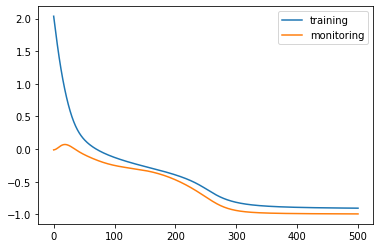

In [23]:
plt.plot(costs_lists['training'])
plt.plot(costs_lists['monitoring'])
plt.legend(['training', 'monitoring'])
plt.show()

Since our example of target Hamiltonian is a single Pauli string, we know 
without needing any training that it has only $\pm 1$ eigenvalues. 
It is a very simple example. but we see that the training of our circuit using
the gadget Hamiltonian as cost function did indeed allow to reach the 
global minimum of the target cost function. 

References  
[1] our paper on arxiv  
[2] Cerezo, M., Sone, A., Volkoff, T. et al. Cost function dependent barren plateaus in shallow parametrized quantum circuits. Nat Commun 12, 1791 (2021). https://doi.org/10.1038/s41467-021-21728-w  